### Exercise 1. GAN for CIFAR-10

Modify the code above to train on CIFAR-10.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
import tensorflow as tf

import random
import matplotlib.pyplot as plt
import sys
import numpy as np

# Configure TensorFlow to use Metal GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Physical devices:", tf.config.list_physical_devices())

# Set memory growth for GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for Metal GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configured: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found. Using CPU.")

TensorFlow version: 2.16.2
Num GPUs Available:  1
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU configured: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from keras.datasets import cifar10

batch_size = 256 

(X_train, _), (_, _) = cifar10.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
train_iterator = iter(dataset.repeat())
print(dataset)

2025-11-30 13:59:43.923002: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-30 13:59:43.923079: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-30 13:59:43.923094: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-30 13:59:43.923126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 13:59:43.923149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<_PrefetchDataset element_spec=TensorSpec(shape=(256, 32, 32, 3), dtype=tf.float32, name=None)>


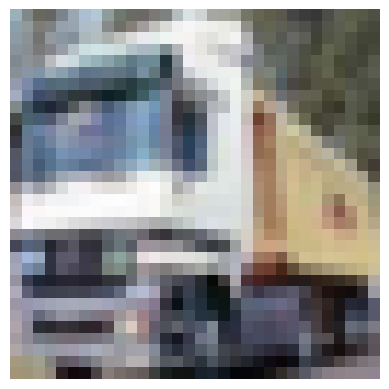

In [3]:
def display_rgb_image(image, normalize=True):
    # Convert tensor to numpy if needed
    if hasattr(image, 'numpy'):
        image = image.numpy()
    
    # Normalize from [-1, 1] to [0, 1] if needed
    if normalize:
        image = (image + 1.0) / 2.0
    
    # Clip values to valid range [0, 1]
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

display_rgb_image(X_train[1])



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3072)           │     3,148,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,838,720 (14.64 MB)

 Trainable params: 3,835,136 (14.63 MB)

 Non-trainable params: 3,584 (14.00 KB)

(1, 32, 32, 3)


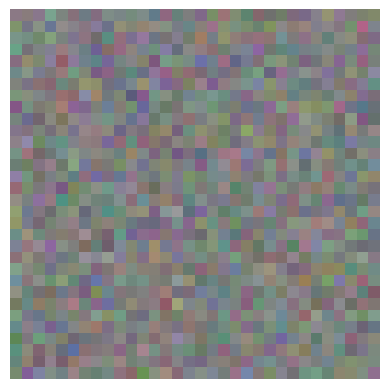

In [4]:
noise_shape = (100,)
img_shape = (32,32,3)

def make_generator_model():
    model = Sequential()
    model.add(Input(shape=noise_shape))
    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(32 * 32 * 3, activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()
    
    return model 

generator = make_generator_model()
noise = tf.random.normal([1, 100])
fake_image = generator(noise, training=False)

print(fake_image.shape)
display_rgb_image(fake_image[0])



In [5]:
def make_discriminator_model():
    model = Sequential()
    
    model.add(Input(shape=img_shape))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    return model

discriminator = make_discriminator_model()
validity = discriminator(fake_image, training=False)

print(validity)
    

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,803,137 (14.51 MB)

 Trainable params: 3,803,137 (14.51 MB)

 Non-trainable params: 0 (0.00 B)

tf.Tensor([[0.4832012]], shape=(1, 1), dtype=float32)


In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [12]:
def print_imgs():
    r, c = 2, 10  # 2 rows, 10 columns = 20 images
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise, verbose=0)

    # Normalize from [-1, 1] to [0, 1] for display
    gen_imgs = (gen_imgs + 1.0) / 2.0
    gen_imgs = np.clip(gen_imgs, 0, 1)
    
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            # CIFAR-10 is RGB (3 channels), so no need for cmap='gray'
            # Just use the full image array
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.tight_layout()
    plt.show()
    plt.close()

/Users/buudinhha/PycharmProjects/deep-learning-2/tf_keras_env/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


0 [D loss: 0.6368] [G loss: 1.3742]


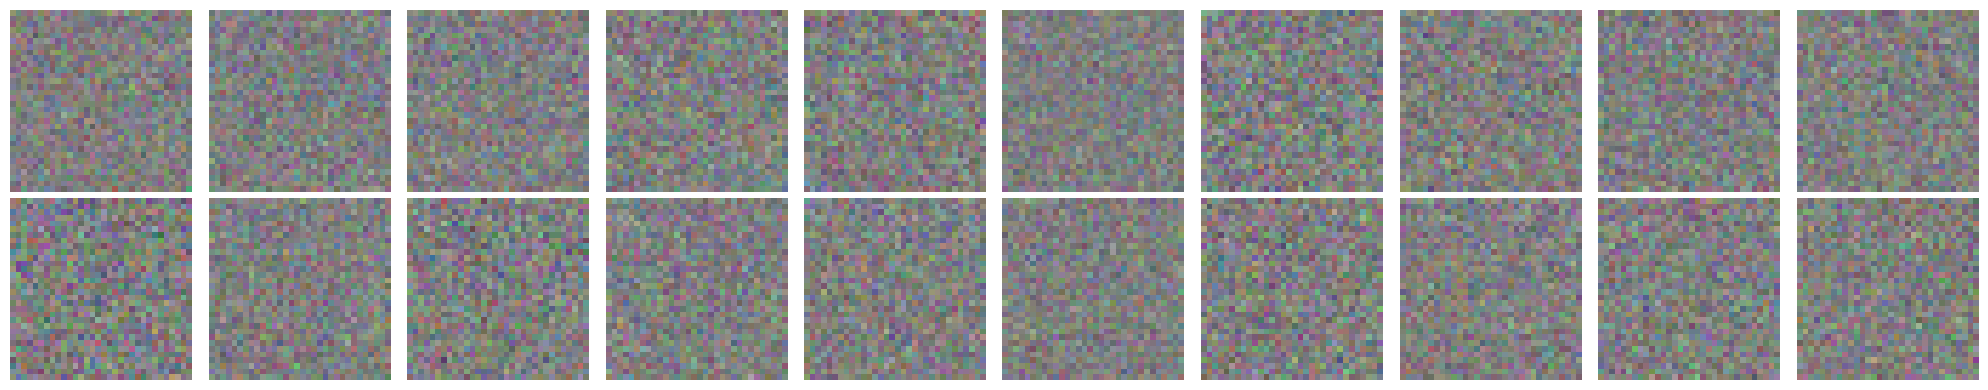

1000 [D loss: 6.4604] [G loss: 0.3354]


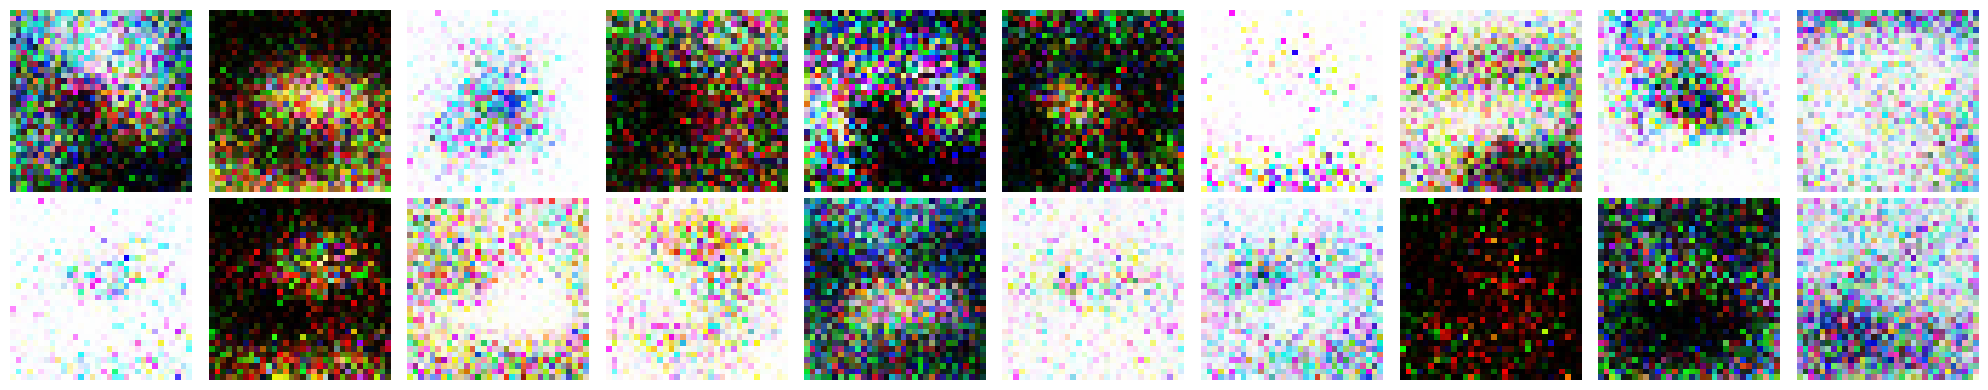

2000 [D loss: 6.9893] [G loss: 0.2350]


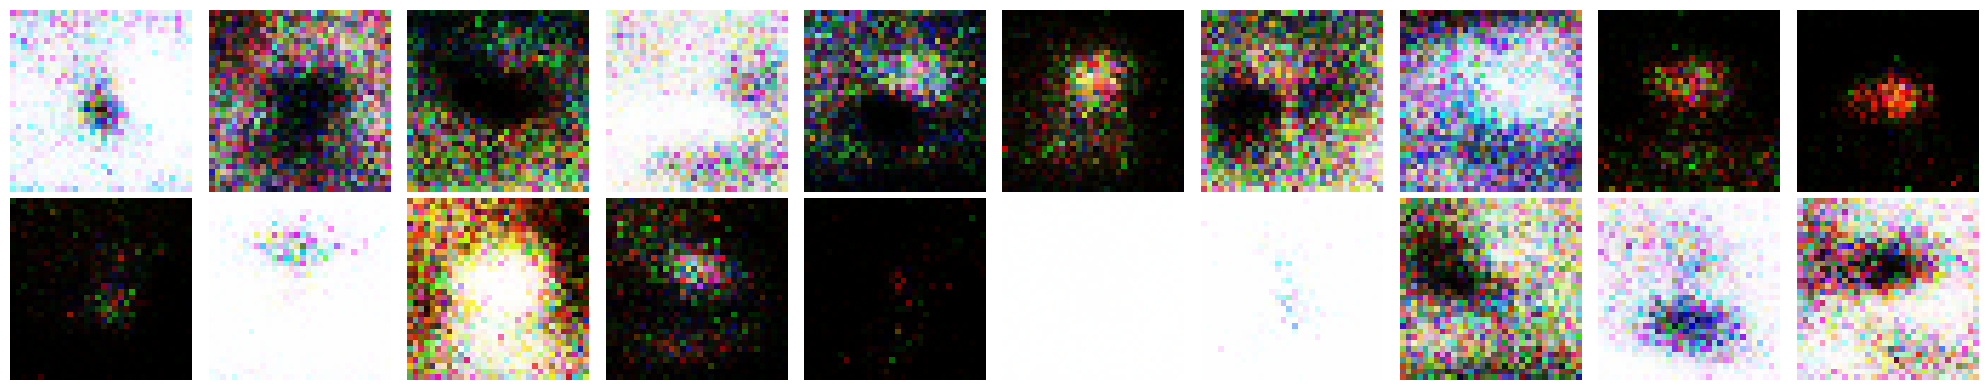

3000 [D loss: 6.6934] [G loss: 0.1928]


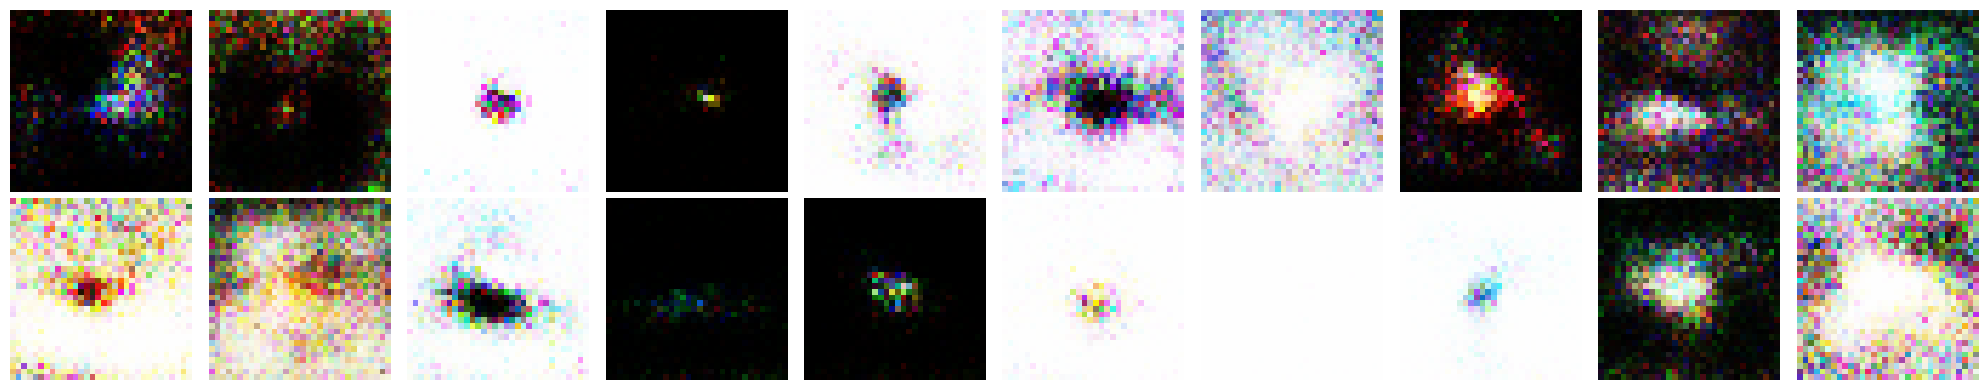

4000 [D loss: 3.9450] [G loss: 0.3999]


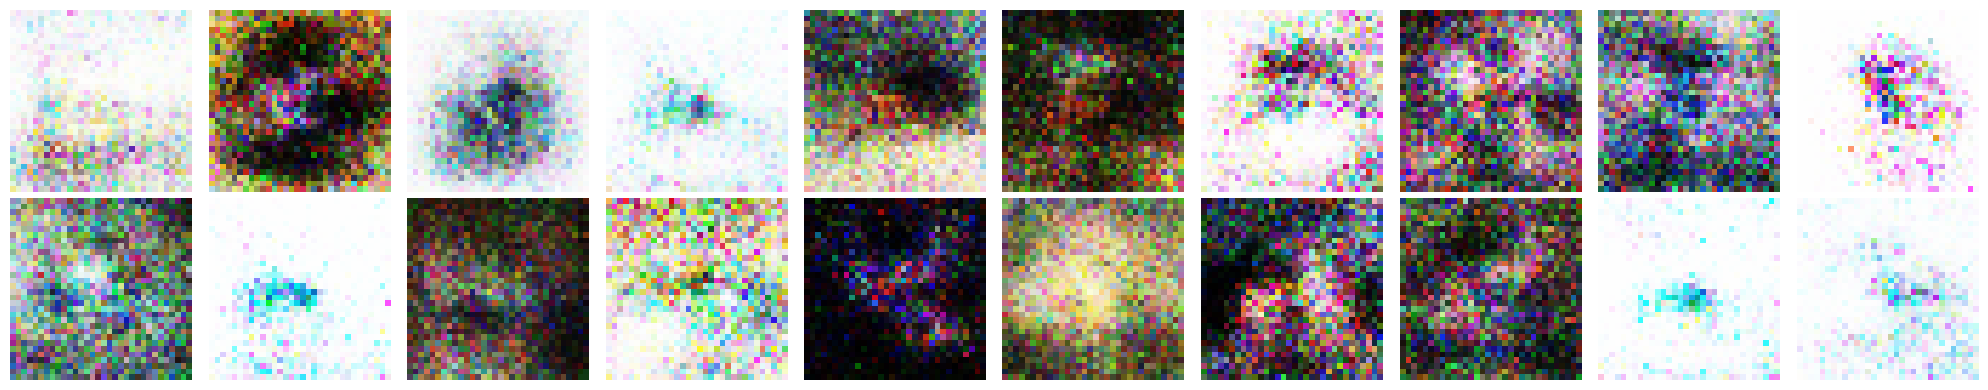

5000 [D loss: 5.4295] [G loss: 0.1827]


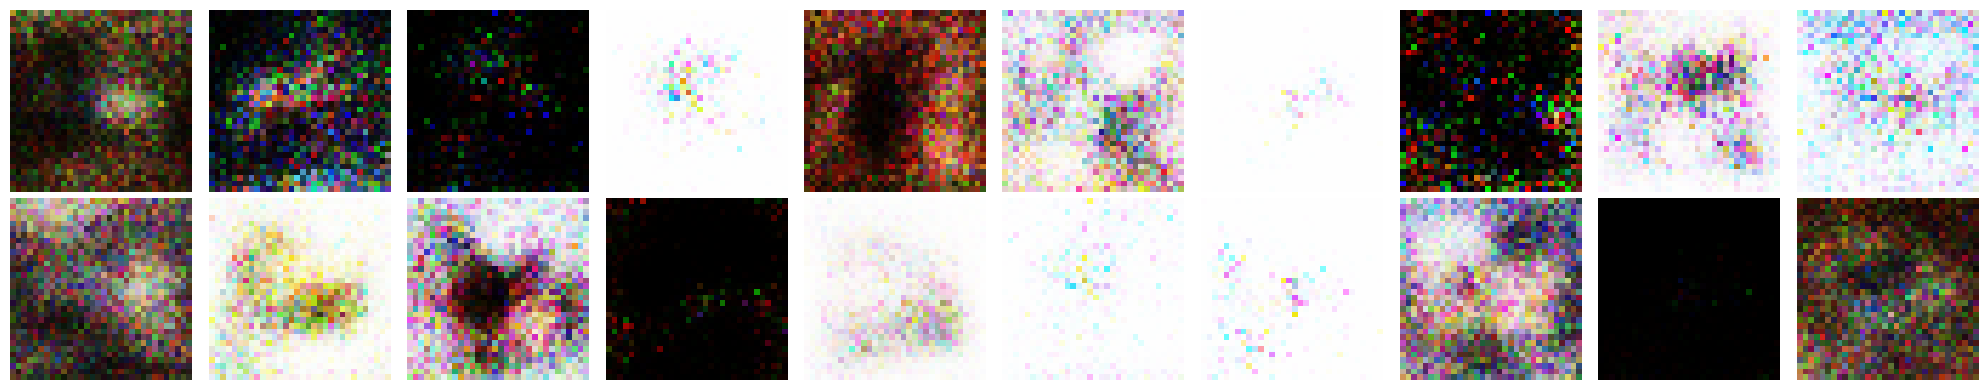

6000 [D loss: 6.5229] [G loss: 0.1727]


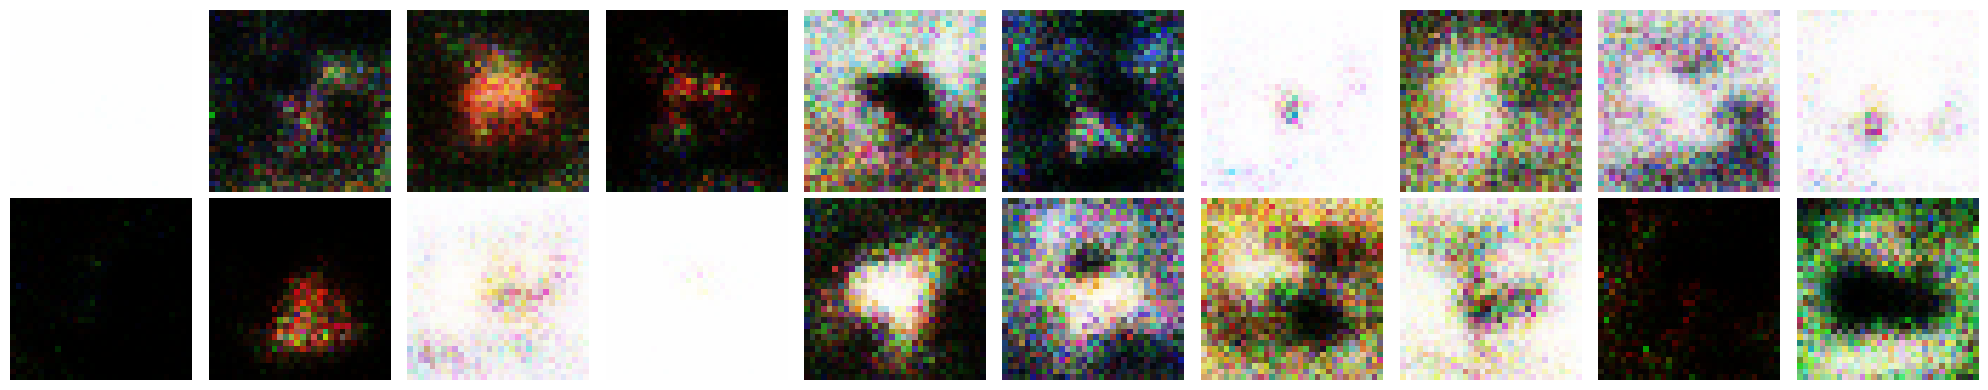

7000 [D loss: 4.4289] [G loss: 0.3213]


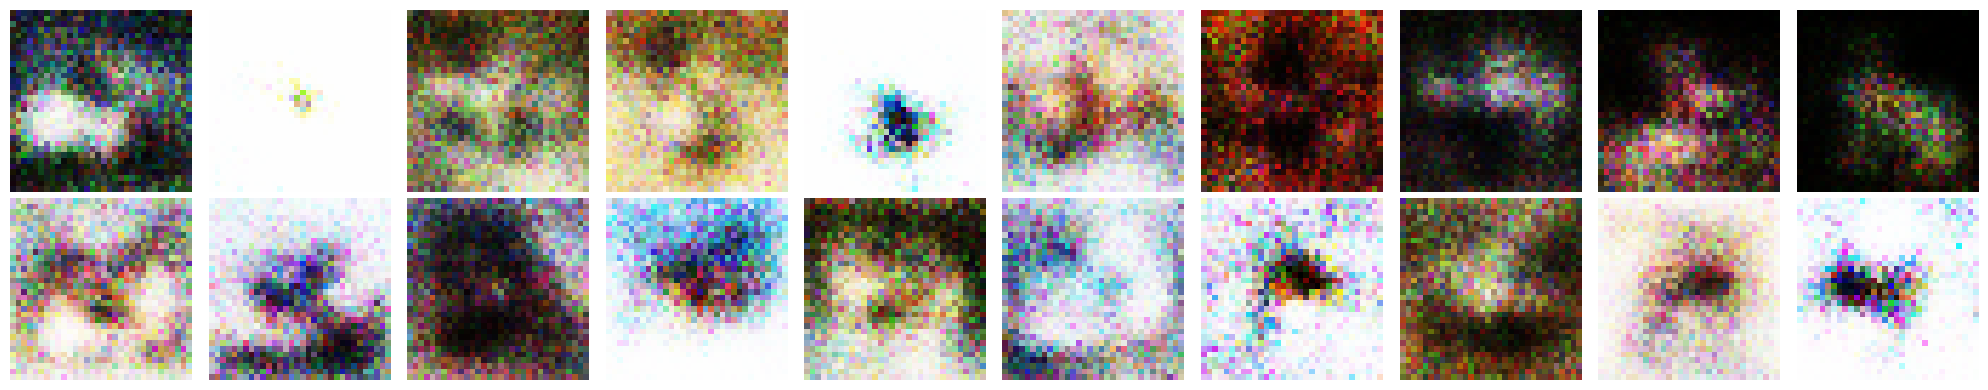

8000 [D loss: 4.8792] [G loss: 0.3143]


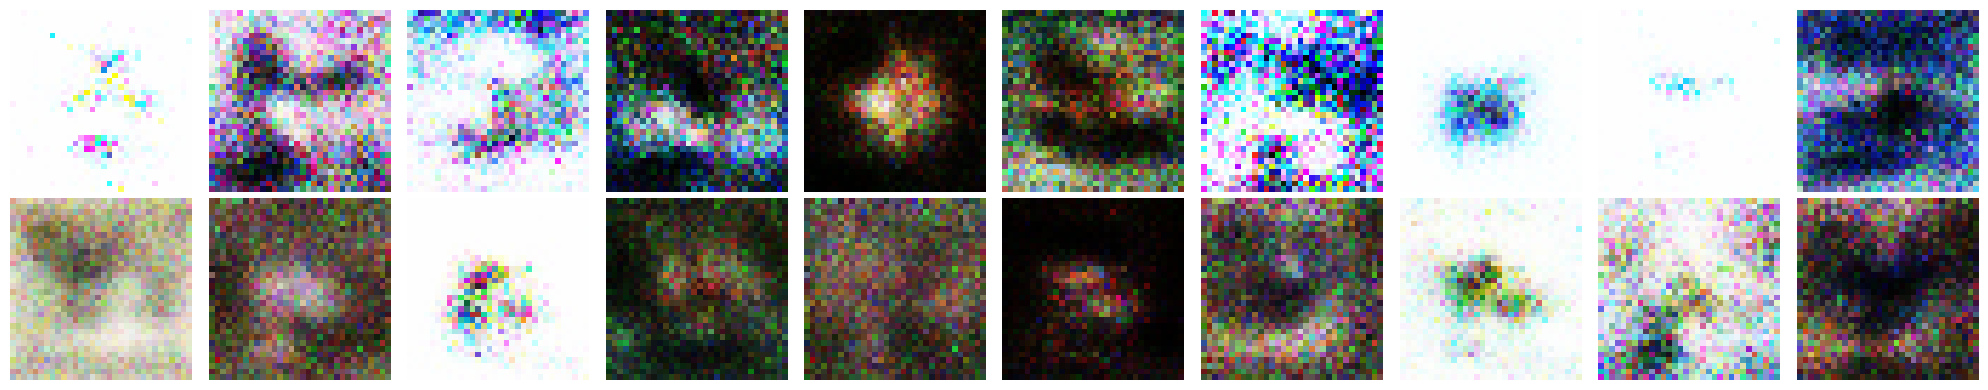

9000 [D loss: 6.9470] [G loss: 0.3160]


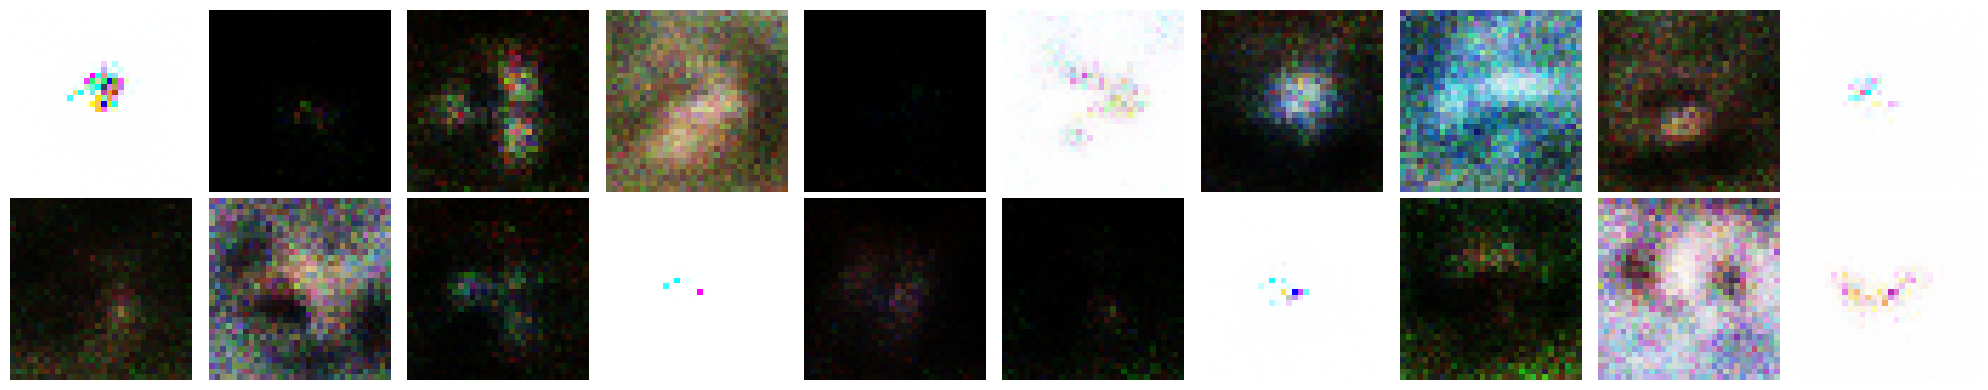

Training finished in 402.84s


In [13]:
import time

epochs = 10000
start_time = time.time()

for epoch in range(epochs):
    batch_imgs = next(train_iterator)
    d_loss, g_loss = train_step(batch_imgs)

    if epoch % 1000 == 0:
        print (f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
        print_imgs()
        
print(f"Training finished in {time.time() - start_time:.2f}s")